<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/ACF/ACF_and_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)
df['DT'] = pd.to_datetime(df['DT'])
df = df.set_index('DT')
df = df.iloc[::-1]

Mounted at /content/drive


In [ ]:
#training and test
training = df.iloc[:-16,:]
print(training.index)
testing = df.iloc[-16:, :]
testing.head()

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='DT', length=1802, freq=None)


,ANTAL_01
DT,
2022-11-30,32207
2022-12-01,32524
2022-12-02,32418
2022-12-05,30902
2022-12-06,30743


In [ ]:
# calculate ACF on the whole dataset
acf = sm.tsa.acf(df['ANTAL_01'], nlags=len(training)-1)

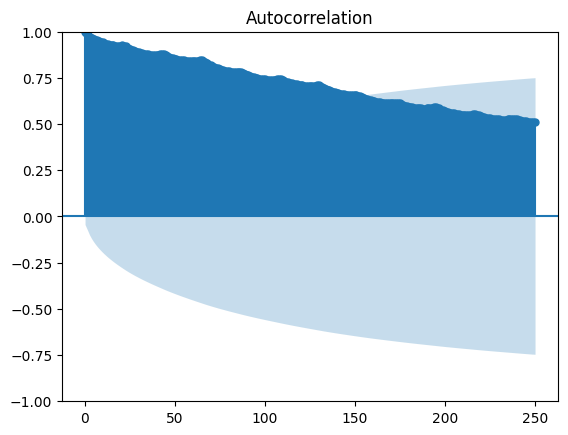

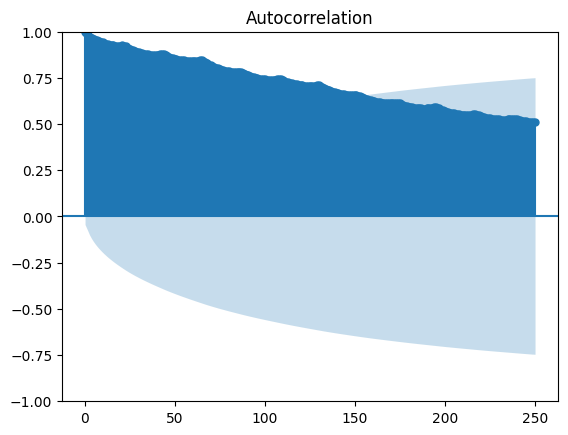

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(training, lags = 250) 

In [ ]:
# create a DataFrame with the repeated ACF values as a column
exog = pd.DataFrame({'acf': acf}, index=training.index)

In [ ]:
# drop any rows with missing values from the exog dataframe
exog = exog.dropna()

In [ ]:
np.asarray(training)

array([['46084'],
       ['46026'],
       ['46108'],
       ...,
       ['31068'],
       ['31054'],
       ['30906']], dtype=object)

In [ ]:
# fit SARIMAX model with exogenous variable
model = sm.tsa.SARIMAX(training['ANTAL_01'].astype(float), exog=np.asarray(exog), order=(1,1,1), seasonal_order=(1,0,1,22))
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
exogTest = exog.tail(22)
exogTest2 = exogTest.head(len(testing))
exogTest2
exogvar = np.asarray(exogTest2['acf'])
exogvar

array([-0.02647461, -0.02649847, -0.02655907, -0.02656575, -0.02636646,
       -0.02613324, -0.02586877, -0.02557794, -0.02528877, -0.02497852,
       -0.02465314, -0.0242821 , -0.02388863, -0.02345598, -0.02298385,
       -0.02247641])

In [ ]:
# make predictions with the fitted model and exogenous variables for test dataset
test_exog = pd.DataFrame({'acf': exogvar}, index=testing.index)
test_exog

,acf
DT,
2022-11-30,-0.026475
2022-12-01,-0.026498
2022-12-02,-0.026559
2022-12-05,-0.026566
2022-12-06,-0.026366
2022-12-07,-0.026133
2022-12-08,-0.025869
2022-12-09,-0.025578
2022-12-12,-0.025289


In [ ]:
# predict using SARIMAX model
pred = result.predict(start=len(training), end=len(training)+len(testing)-1, exog=test_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


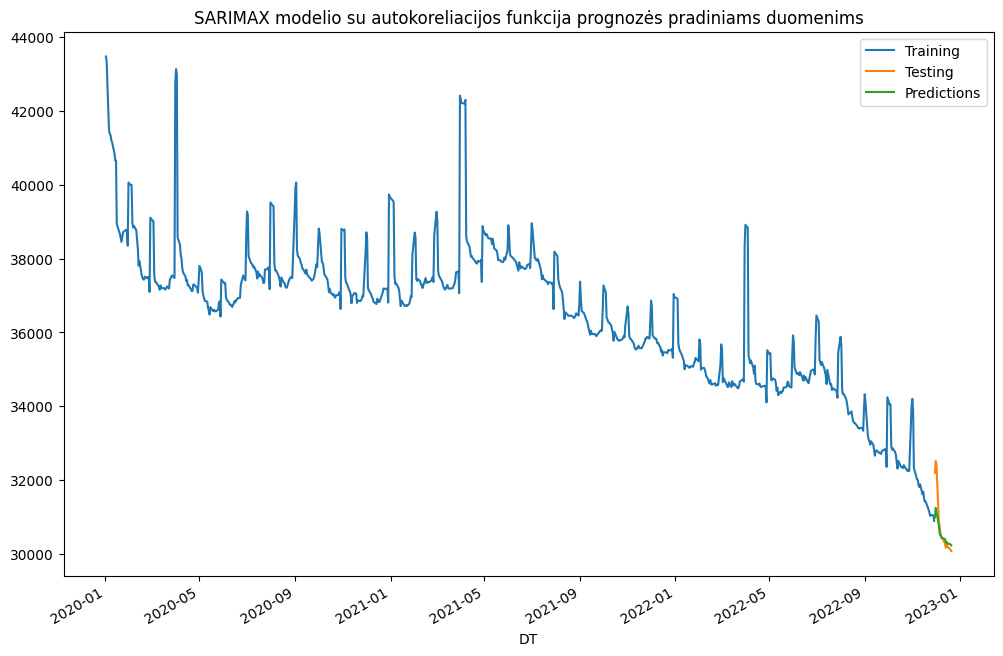

In [ ]:
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
testing['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = testing.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su autokoreliacijos funkcija prognozės pradiniams duomenims')
plt.legend()

In [ ]:
pred, testing['ANTAL_01']

(DT
 2022-11-30    30997.256169
 2022-12-01    31257.058213
 2022-12-02    31138.673683
 2022-12-05    30794.222992
 2022-12-06    30577.015943
 2022-12-07    30512.415543
 2022-12-08    30501.697806
 2022-12-09    30443.086670
 2022-12-12    30426.842781
 2022-12-13    30405.038254
 2022-12-14    30327.035884
 2022-12-15    30339.932345
 2022-12-16    30295.198603
 2022-12-19    30278.642795
 2022-12-20    30272.565994
 2022-12-21    30241.613538
 Name: predicted_mean, dtype: float64,
 DT
 2022-11-30    32207
 2022-12-01    32524
 2022-12-02    32418
 2022-12-05    30902
 2022-12-06    30743
 2022-12-07    30590
 2022-12-08    30455
 2022-12-09    30444
 2022-12-12    30339
 2022-12-13    30277
 2022-12-14    30179
 2022-12-15    30280
 2022-12-16    30213
 2022-12-19    30152
 2022-12-20    30121
 2022-12-21    30090
 Name: ANTAL_01, dtype: object)